# Load Trained Q and Policy

In [56]:
import pickle
from train import BaseState, Action

agent_name = "MCE5"

save_path = f"results/agent_{agent_name}"

with open(f"{save_path}/policy.pkl", "rb") as f:
    policy = pickle.load(f)
with open(f"{save_path}/Q.pkl", "rb") as f:
    Q = pickle.load(f)

print(policy)
print(Q)

# for s, a in Q:
#     print(f"State: {s}, Action: {a}, Q-value: {Q[(s, a)]}")

# for s in policy:
#     print(f"State: {s}, Action: {policy[s]}")

{BaseState(player_sum=14, dealer_card=4, usible_ace=False, splitable=False, can_double=True): <Action.Stand: 0>, BaseState(player_sum=16, dealer_card=4, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=7, dealer_card=11, usible_ace=False, splitable=False, can_double=True): <Action.Hit: 1>, BaseState(player_sum=20, dealer_card=4, usible_ace=True, splitable=False, can_double=True): <Action.Stand: 0>, BaseState(player_sum=14, dealer_card=11, usible_ace=False, splitable=False, can_double=True): <Action.Hit: 1>, BaseState(player_sum=18, dealer_card=3, usible_ace=False, splitable=False, can_double=True): <Action.Stand: 0>, BaseState(player_sum=12, dealer_card=7, usible_ace=False, splitable=False, can_double=True): <Action.Hit: 1>, BaseState(player_sum=9, dealer_card=6, usible_ace=False, splitable=False, can_double=True): <Action.Double: 2>, BaseState(player_sum=12, dealer_card=6, usible_ace=False, splitable=False, can_double=False): <Action.Hit: 1

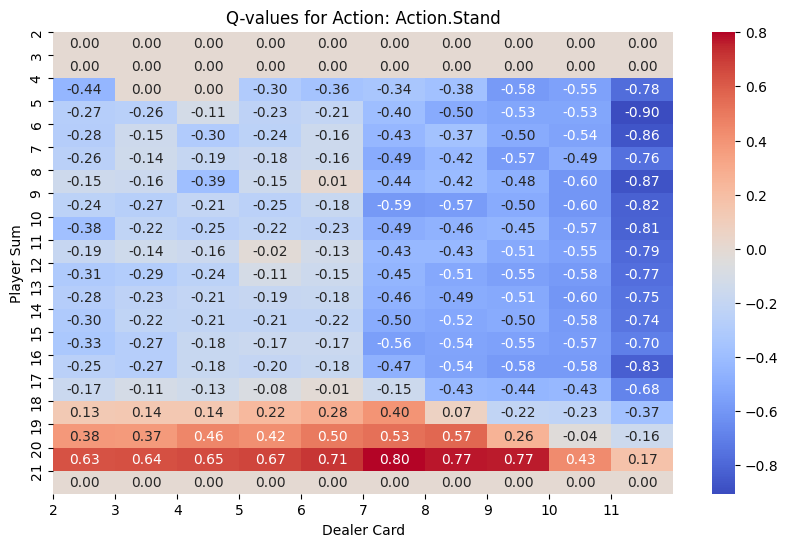

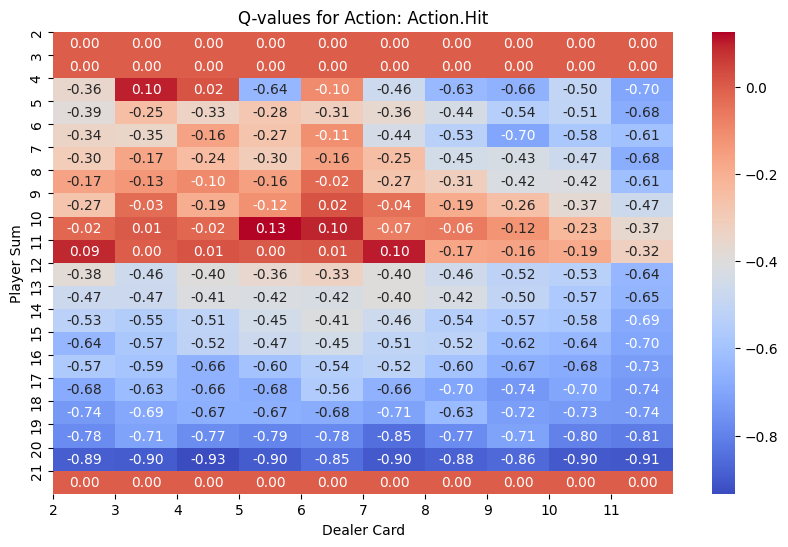

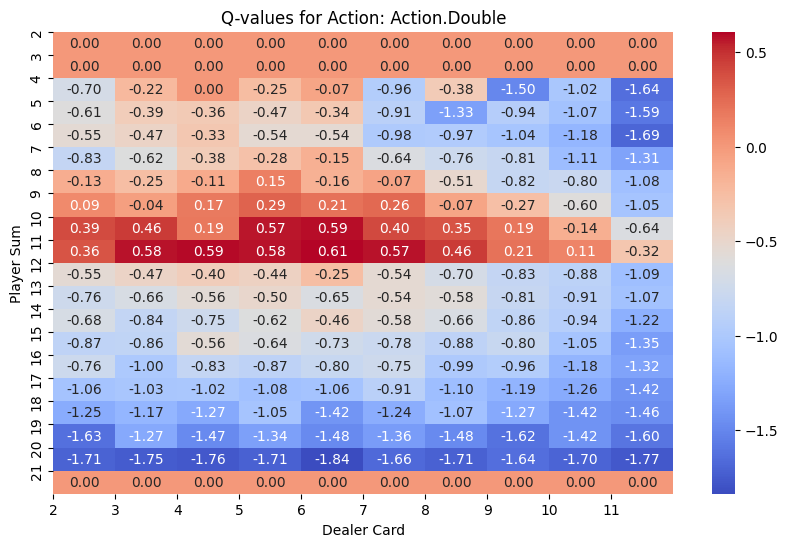

In [57]:
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# split q a tables
player_sums = range(2, 22)  # player sums from 2 to 21
dealer_cards = range(2, 12)

enable_split = False

# action tables
action_tables = {}
for action in [Action.Stand, Action.Hit, Action.Double]:
    action_tables[action] = np.zeros((len(player_sums), len(dealer_cards)))
    for i, player_sum in enumerate(player_sums):
        for j, dealer_card_value in enumerate(dealer_cards):
            state = BaseState(
                player_sum=player_sum,
                dealer_card=dealer_card_value,
                usible_ace=False,
                splitable=enable_split,
                can_double=True,
            )
            if state in Q and action in Q[state]:
                action_tables[action][i, j] = Q[state][action]


for action, table in action_tables.items():
    plt.figure(figsize=(10, 6))
    # plt.imshow(table, cmap='hot', interpolation='nearest')
    sns.heatmap(table, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
                xticklabels=dealer_cards, yticklabels=player_sums)
    # plt.colorbar(label='Q-value')
    plt.title(f'Q-values for Action: {action}')
    plt.xlabel('Dealer Card')
    plt.ylabel('Player Sum')
    plt.xticks(ticks=np.arange(len(dealer_cards)), labels=dealer_cards)
    plt.yticks(ticks=np.arange(len(player_sums)), labels=player_sums)
    plt.show()


# Show Optimal Policy
## Split Policy

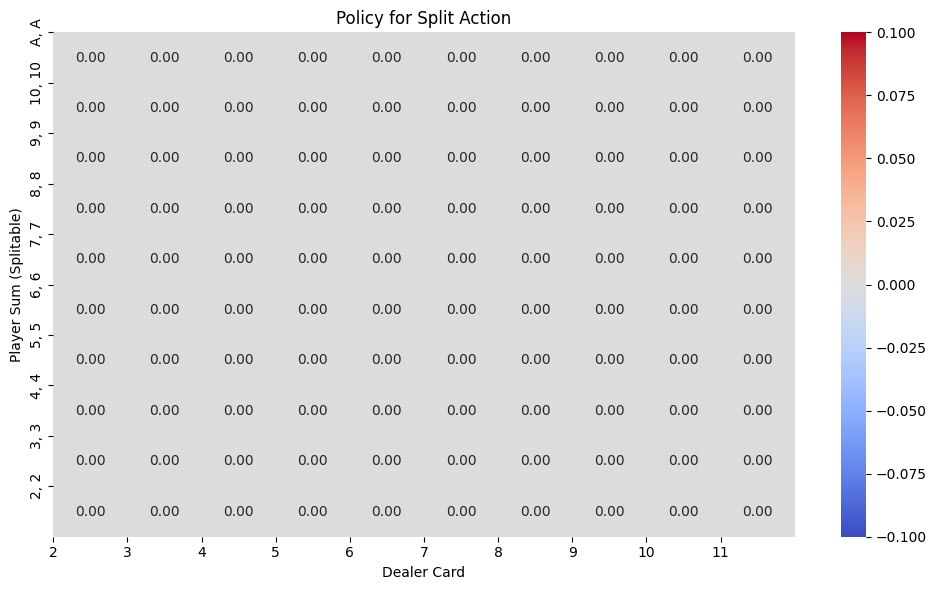

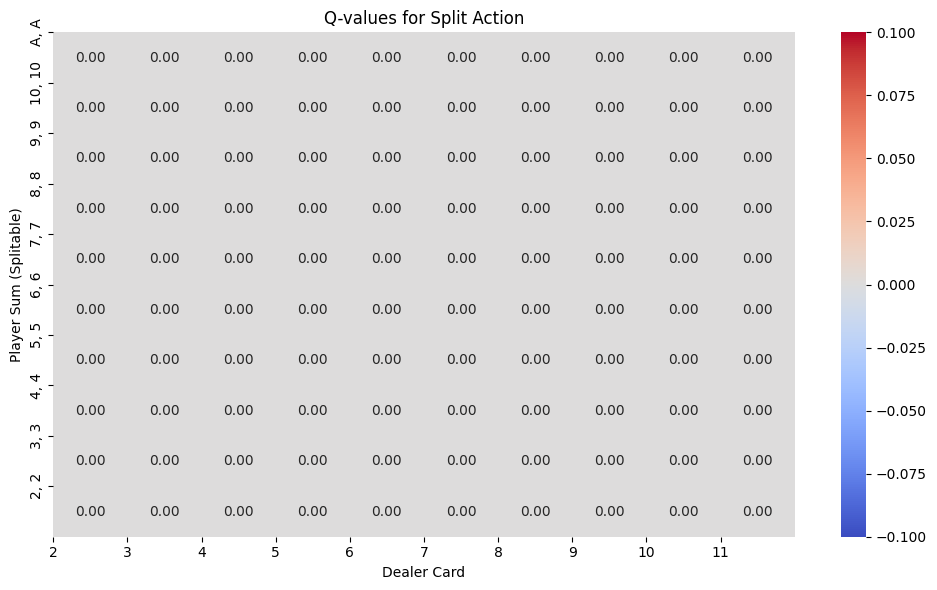

In [58]:
# split situation
splitable_player_sums = range(22, 2, -2)  
splitable_player_sum_labels = [f"{s//2}, {s//2}" for s in splitable_player_sums]
splitable_player_sum_labels[0] = 'A, A'  # for 22, which is a pair of aces

dealer_cards = range(2, 12)

split_policy = np.zeros((len(splitable_player_sums), len(dealer_cards)))
split_policy_values = np.zeros((len(splitable_player_sums), len(dealer_cards)))
for i, player_sum in enumerate(splitable_player_sums):
    for j, dealer_card_value in enumerate(dealer_cards):
        has_ace = False
        if player_sum == 22:
            # player has a usable ace
            has_ace = True
            player_sum = 12
        state = BaseState(
            player_sum=player_sum,
            dealer_card=dealer_card_value,
            usible_ace=has_ace,
            splitable=True,
            can_double=True
        )
        action  = policy.get(state)
        if action is None:
            continue
        split_policy[i, j] = action == Action.Split
        if action not in Q[state]:
            print(state, action, "Not possible?")
            continue
        split_policy_values[i, j] = Q[state][action]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(split_policy, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
            xticklabels=dealer_cards, yticklabels=splitable_player_sum_labels)

plt.title('Policy for Split Action')
plt.xlabel('Dealer Card')
plt.ylabel('Player Sum (Splitable)')
plt.xticks(ticks=np.arange(len(dealer_cards)), labels=dealer_cards)
plt.yticks(ticks=np.arange(len(splitable_player_sums)), labels=splitable_player_sum_labels)
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.heatmap(split_policy_values, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
            xticklabels=dealer_cards, yticklabels=splitable_player_sums)
plt.title('Q-values for Split Action')
plt.xlabel('Dealer Card')
plt.ylabel('Player Sum (Splitable)')
plt.xticks(ticks=np.arange(len(dealer_cards)), labels=dealer_cards)
plt.yticks(ticks=np.arange(len(splitable_player_sums)), labels=splitable_player_sum_labels)
plt.tight_layout()

plt.show()
        

## Soft Totals
Player has soft Ace

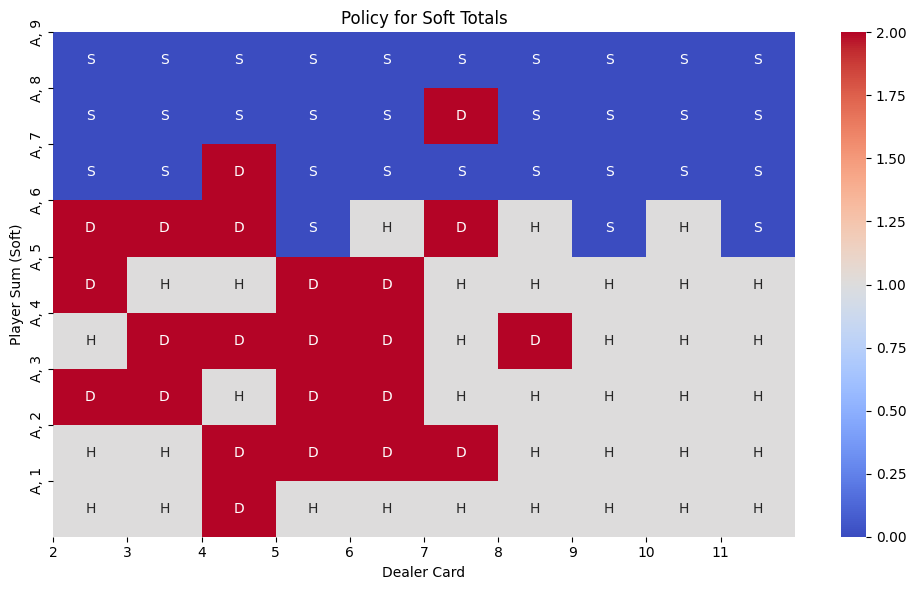

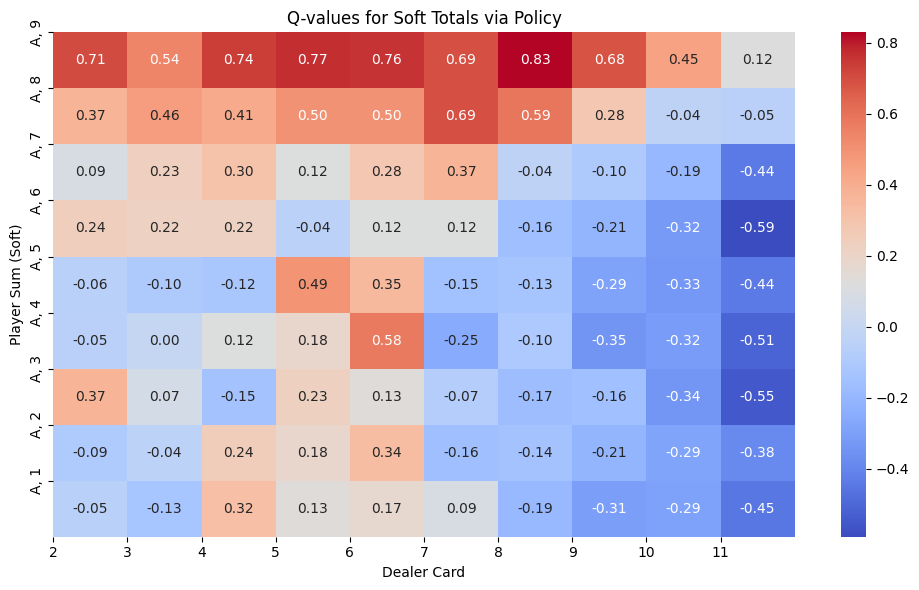

In [62]:
# split situation
soft_plyer_sums = range(20, 11, -1) # remind AA count as 12 here
soft_player_sum_labels = [f"A, {s-11}" for s in soft_plyer_sums]

soft_policy = np.zeros((len(soft_plyer_sums), len(dealer_cards)))
soft_policy_labels = np.array(['']*len(soft_plyer_sums)*len(dealer_cards)).reshape(len(soft_plyer_sums), len(dealer_cards))

soft_policy_values = np.zeros((len(soft_plyer_sums), len(dealer_cards)))
for i, player_sum in enumerate(soft_plyer_sums):
    for j, dealer_card_value in enumerate(dealer_cards):
        state = BaseState(
            player_sum=player_sum,
            dealer_card=dealer_card_value,
            usible_ace=True,
            splitable=enable_split,  # only splitable if player sum is 12 (AA)
            can_double=True
        )
        action  = policy.get(state)
        if action is None:
            continue
        soft_policy[i, j] = action.value
        soft_policy_labels[i, j] = action.name[0]  # use first letter of action name
        soft_policy_values[i, j] = Q[state][action]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(soft_policy, annot=soft_policy_labels, fmt='', cmap='coolwarm', cbar=True, 
            xticklabels=dealer_cards, yticklabels=soft_player_sum_labels)
plt.title('Policy for Soft Totals')
plt.xlabel('Dealer Card')
plt.ylabel('Player Sum (Soft)')
plt.xticks(ticks=np.arange(len(dealer_cards)), labels=dealer_cards)
plt.yticks(ticks=np.arange(len(soft_plyer_sums)), labels=soft_player_sum_labels)
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.heatmap(soft_policy_values, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
            xticklabels=dealer_cards, yticklabels=soft_player_sum_labels)
plt.title('Q-values for Soft Totals via Policy')
plt.xlabel('Dealer Card')
plt.ylabel('Player Sum (Soft)')
plt.xticks(ticks=np.arange(len(dealer_cards)), labels=dealer_cards)
plt.yticks(ticks=np.arange(len(soft_player_sum_labels)), labels=soft_player_sum_labels)
plt.tight_layout()

plt.show()
        

# Hard Totals

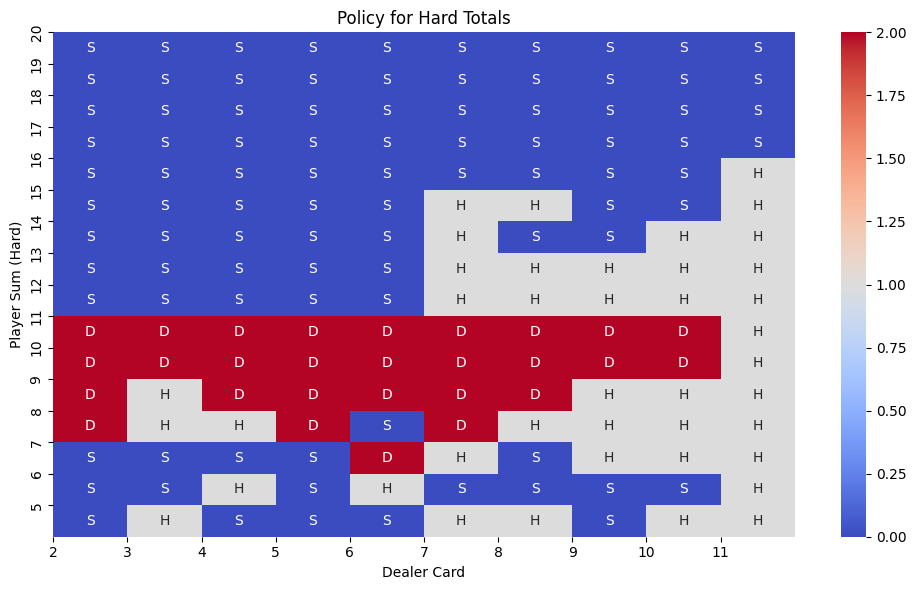

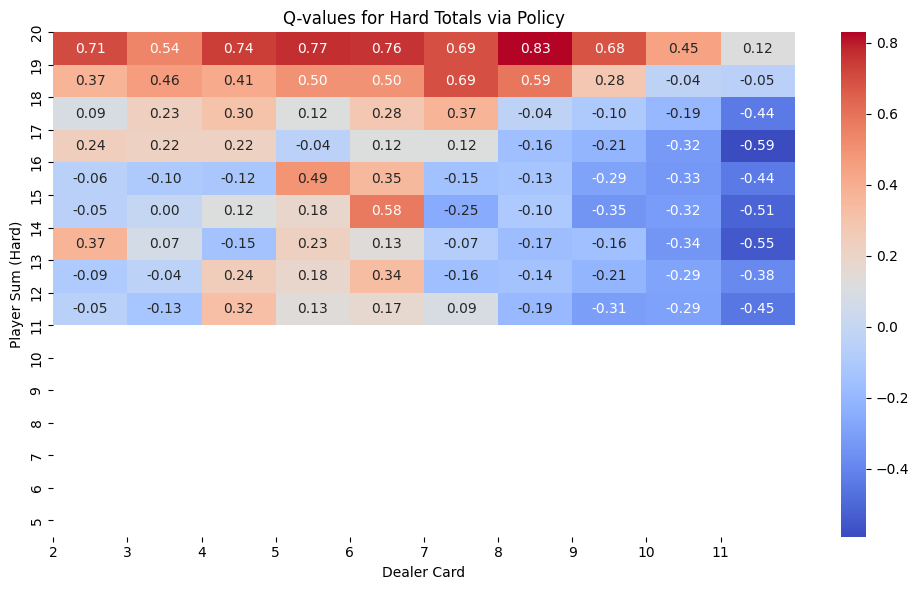

In [64]:
# split situation
hard_player_sums = range(20, 4, -1) # remind AA count as 12 here

hard_policy = np.zeros((len(hard_player_sums), len(dealer_cards)))
hard_policy_labels = np.array(['']*len(hard_player_sums)*len(dealer_cards)).reshape(-1, len(dealer_cards))
hard_policy_values = np.zeros((len(hard_player_sums), len(dealer_cards)))
for i, player_sum in enumerate(hard_player_sums):
    for j, dealer_card_value in enumerate(dealer_cards):
        state = BaseState(
            player_sum=player_sum,
            dealer_card=dealer_card_value,
            usible_ace=False,
            splitable=enable_split,
            can_double=True,
        )
        action  = policy.get(state)
        if action is None:
            continue
        hard_policy[i, j] = action.value
        hard_policy_labels[i, j] = action.name[0]  # use first letter of action name
        hard_policy_values[i, j] = Q[state][action]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(hard_policy, annot=hard_policy_labels, fmt='', cmap='coolwarm', cbar=True, 
            xticklabels=dealer_cards, yticklabels=hard_player_sums)
plt.title('Policy for Hard Totals')
plt.xlabel('Dealer Card')
plt.ylabel('Player Sum (Hard)')
plt.xticks(ticks=np.arange(len(dealer_cards)), labels=dealer_cards)
plt.yticks(ticks=np.arange(len(hard_player_sums)), labels=hard_player_sums)
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.heatmap(soft_policy_values, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
            xticklabels=dealer_cards, yticklabels=hard_player_sums)
plt.title('Q-values for Hard Totals via Policy')
plt.xlabel('Dealer Card')
plt.ylabel('Player Sum (Hard)')
plt.xticks(ticks=np.arange(len(dealer_cards)), labels=dealer_cards)
plt.yticks(ticks=np.arange(len(hard_player_sums)), labels=hard_player_sums)
plt.tight_layout()

plt.show()
        